# Multipoint Detection With Varying number of objects

This is based on Convolutional_MNIST_Multipoint_Detection

Expanding to account for cases where we do not know how many objects are actually in the image. Taking the Convolutional_MNIST_Multipoint_Detection model and adding in a measure to compute the confidence of each detection. Using this we can train the model to find up to an arbitrary maximum number of items in an image.

Using the concept of an anchor box here to tell the model what size each detector is responsable for detecting. each detector has a range of sizes that it is responsible for detecting. when using 2 images and a rescale range of [0.75,1.25], one detector is responsible for detecting objects that were scaled < 1, and the other is responsible for >1.

This model is starting off with a large image of size 64x64, with upto 2 items in the image.

As with YOLO, using sum square errors for loss function across all 

In [1]:
import numpy as np
import cv2

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten, Activation, Lambda
from keras.layers import Reshape, concatenate,Concatenate
from keras.datasets import mnist
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras import losses
from keras import backend as K

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,10)

Using TensorFlow backend.


In [2]:
batch_size = 24
num_classes = 10
epochs = 5
n_images = 2

# Shape of the large images we are putting the numbers into
large_image_shape = (64,64)

# Checkpoint folder
model_data_folder = "/dataset/MNIST_Tracking/Convolutional_MNIST_Multipoint_Detection_With_Confidence_data/"

In [3]:
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1], x_train.shape[2])
    x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1], x_test.shape[2])
    input_shape = (1,x_test.shape[1], x_test.shape[2])
else:
    x_train = x_train.reshape(x_train.shape[0],  x_train.shape[1], x_train.shape[2], 1)
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
    input_shape = (x_test.shape[1], x_test.shape[2], 1)

In [4]:
def generate_inputs(x,y,batch_size = 128, n_classes = 10, large_image_shape = (64,64),n_images = 2):
    '''
    Using an MNIST number, make a video with the number randomly located and moving.
    
    n_classes: 10, fixed for MNIST
    large_image_shape: the shape of the output video
    max_speed: The max speed the number can travel across the frame in pixels/frame
    '''      
    # set scales
    scale_range = [.75,1.5] # range at which to scale the images 
    scales = np.linspace(scale_range[0],scale_range[1],n_images+1) # get scale ranges for each anchor box.
    
    confidence_cutoff = 0.75 # if a uniform random number is < this, then populate that anchor with an image
    
    n_samples,n_rows,n_cols,n_chan = x.shape
    num_batches = np.round(float(n_samples)/float(batch_size)-.5)
    
    y = keras.utils.to_categorical(y, n_classes)
    
    while 1:
        sample_order = np.random.permutation(x.shape[0])
        x_out = np.zeros((batch_size,large_image_shape[0],large_image_shape[1],n_chan),dtype = x.dtype)
        location_out = np.zeros((batch_size,1,1,n_images,2),dtype=np.float32)
        class_out = np.zeros((batch_size,1,1,n_images,n_classes),dtype=np.float32)
        confidence = np.zeros((batch_size,1,1,n_images,1),dtype=np.float32)
        
        permute_counter = 0
        for ii in range(batch_size):
            for jj in range(n_images):
                # Should we populate this anchor
                if np.random.uniform(0.0,1.0) > confidence_cutoff:
                    continue
                permute_counter += 1
                
                confidence[ii,0,0,jj,0] = 1.
                # find how large the new image is. Do some halfing and doubling so we end up with even dimensions
                # even dimensions make placing into the large image easier
                img_scale = np.random.uniform(scales[jj],scales[jj+1])
                n_rows_scale = 2*np.around(n_rows * img_scale/2).astype(np.uint8)
                n_cols_scale = 2*np.around(n_cols * img_scale/2).astype(np.uint8)
                # initialize the limits on where the the number can start
                limits = np.array([[int(n_rows_scale/2),large_image_shape[0]-int(n_rows_scale/2)],
                                   [int(n_cols_scale/2),large_image_shape[1]-int(n_cols_scale/2)]])

                #initialize and create starting point
                location = np.zeros((2))
                location[0] = np.random.randint(limits[0,0],limits[0,1])
                location[1] = np.random.randint(limits[1,0],limits[1,1])
                location = location.astype(np.int)
                # convert to relative distance across image
                location_out[ii,0,0,jj,0]=location[0]/large_image_shape[0]
                location_out[ii,0,0,jj,1]=location[1]/large_image_shape[1]
                
                # Resize the image and place into output image.
                # Note that this can cause an overflow if the images overlap.
                # a small image on a large image will make the small image appear as a negative.
                x_scaled = cv2.resize(x[sample_order[permute_counter]],(n_rows_scale,n_cols_scale))
                x_scaled = np.expand_dims(x_scaled,axis = -1)
                x_out[ii,
                      int(location[0] - n_rows_scale/2):int(location[0] + n_rows_scale/2),
                      int(location[1] - n_cols_scale/2):int(location[1] + n_cols_scale/2),:] += x_scaled

                class_out[ii,0,0,jj,:] = y[sample_order[permute_counter]]
                
        x_out = x_out.astype(np.float32)/255.
        #print(location_out.shape)
        #print(confidence.shape)
        #print(class_out.shape)
        y_out = np.concatenate((location_out,confidence,class_out),axis=-1)
        
        yield (x_out,y_out)

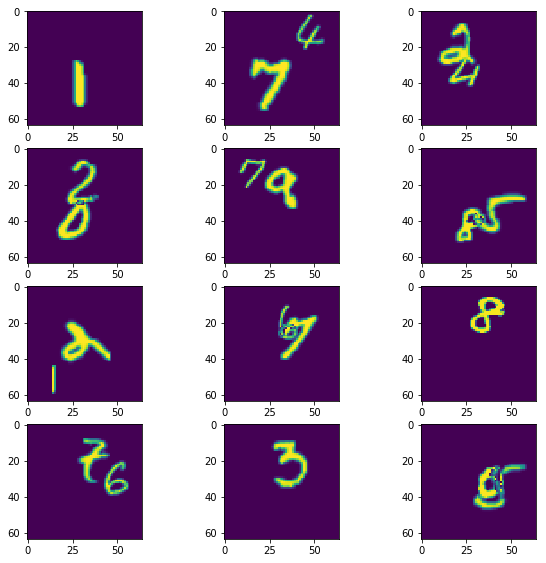

In [5]:
# Take a look at what the images look like
plt.rcParams['figure.figsize'] = (10,30)
dev_batch_size = 12
num_batches = 1

t = generate_inputs(x_train,y_train,batch_size = dev_batch_size, n_classes = 10, n_images=n_images,large_image_shape=large_image_shape)

batch_counter = 0 
for ii in t:
    batch_counter += 1
    data = ii[0]
    n_cols = 3
    n_rows = dev_batch_size
    counter = 0
    img_shape = data[0,:,:,0].shape
    y = ii[1]
    for jj in range(dev_batch_size):
        counter += 1
        plt.subplot(n_rows,n_cols,counter)
        #plt.title('{}'.format(np.argmax(ii[1][jj,0,0,2:])))
        plt.imshow(data[jj,:,:,:].reshape(img_shape[0],img_shape[1]))
    plt.show()
    if batch_counter >= num_batches:
        break


In [12]:
def head(x):
    
    # reshape the input, shape is: [num_rows,num_cols,num_to_detect, classes + location+confidence]
    x = Reshape((1,1,n_images,13))(x)

    locs = K.sigmoid(x[:,:,:,:,:2]) # get locations on [0,1]
    confidence = K.sigmoid(x[:,:,:,:,2]) # get confidence on [0,1]
    classes = K.softmax(x[:,:,:,:,3:]) # so we have 'probabilites' even though not using cross entropy
    
    confidence = K.expand_dims(confidence) # add back the dim that was lost in the sigmoid
    
    #bring it back to 1 tensor so all the info can be passed to the same loss function
    x = K.concatenate([locs,confidence,classes])

    return x

def custom_loss(y_true,y_pred):
    '''
    Loss function loosely based on YOLO
    Scaling the losses to focus more effort on differnt parts
    '''
    
    locs_true = y_true[:,:,:,:,:2]
    confidence_true = y_true[:,:,:,:,2]
    classes_true = y_true[:,:,:,:,3:]
    confidence_true = K.expand_dims(confidence_true,axis=-1)
    
    locs_pred = x[:,:,:,:,:2]
    confidence_pred = x[:,:,:,:,2]
    classes_pred = x[:,:,:,:,3:]
    confidence_pred = K.expand_dims(confidence_pred,axis=-1)
    
    loc_loss = confidence_true * (K.square(locs_true[:,:,:,:,0]-locs_pred[:,:,:,:,0]) + K.square(locs_true[:,:,:,:,1]-locs_pred[:,:,:,:,1]))
    
    # confidence losses, need to have value for how right it is, and how wrong it is. 
    positive_confidence_loss = confidence_true * K.square(confidence_true-confidence_pred)
    negative_confidence_loss = (1-confidence_true) * K.square(confidence_true-confidence_pred)
    
    class_loss = confidence_true * K.square(classes_true-classes_pred)
    
    loc_loss_sum = K.sum(loc_loss)
    confidence_loss_sum = K.sum(positive_confidence_loss) + 0.05*K.sum(negative_confidence_loss)
    class_loss_sum = K.sum(class_loss)
    
    total_loss = loc_loss_sum + confidence_loss_sum + class_loss_sum
    
    return total_loss

def class_acc(y_true,y_pred):
    
    return metrics.categorical_accuracy(y_true,y_pred)

In [13]:
train_gen = generate_inputs(x_train,y_train,batch_size = batch_size, n_classes = 10,n_images=n_images,large_image_shape = large_image_shape)
test_gen = generate_inputs(x_test,y_test,batch_size = batch_size,n_classes = 10,n_images=n_images,large_image_shape = large_image_shape)

In [14]:
from keras.layers import Input
from keras.models import Model

main_input = Input(shape=(large_image_shape[0],large_image_shape[1],1),dtype='float32',name="main_input")
x=Conv2D(filters=32, kernel_size=(3, 3),padding='valid',activation='relu',name='Conv_01')(main_input)
x=Conv2D(filters=32, kernel_size=(3, 3),padding='valid',activation='relu',name='Conv_02')(x)
x=MaxPooling2D(pool_size=(2,2),name="Maxpool_03")(x)
x=Conv2D(filters=32, kernel_size=(3, 3),padding='valid',activation='relu',name="Conv_04")(x)
x=Conv2D(filters=32, kernel_size=(3, 3),padding='valid',activation='relu',name="Conv_05")(x)
x=MaxPooling2D(pool_size=(4,4),name="Maxpool_06")(x)
x=Conv2D(filters=32, kernel_size=(3, 3),padding='valid',activation='relu',name="Conv_07")(x)
x=Conv2D(filters=13*n_images, kernel_size=(4,4),padding='valid',activation='linear',name='Conv_08')(x)

x = Lambda(lambda x:head(x))(x)

model = Model(inputs=main_input, outputs=x)
model.compile(loss=custom_loss,
              optimizer=keras.optimizers.Adadelta(),
              metrics=[class_acc])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 64, 64, 1)         0         
_________________________________________________________________
Conv_01 (Conv2D)             (None, 62, 62, 32)        320       
_________________________________________________________________
Conv_02 (Conv2D)             (None, 60, 60, 32)        9248      
_________________________________________________________________
Maxpool_03 (MaxPooling2D)    (None, 30, 30, 32)        0         
_________________________________________________________________
Conv_04 (Conv2D)             (None, 28, 28, 32)        9248      
_________________________________________________________________
Conv_05 (Conv2D)             (None, 26, 26, 32)        9248      
_________________________________________________________________
Maxpool_06 (MaxPooling2D)    (None, 6, 6, 32)          0         
__________

In [15]:
# tensorboard
tbCallBack = keras.callbacks.TensorBoard(log_dir=model_data_folder, histogram_freq=0, write_graph=True, write_images=True)
#Checkpoints
checkpointer = ModelCheckpoint(filepath=model_data_folder + 'weights.hd5', verbose=1, save_best_only=True)
#logger
csv_logger = keras.callbacks.CSVLogger(model_data_folder+"train_log.csv", separator=',', append=False)

In [16]:
model.fit_generator(train_gen,
          steps_per_epoch = np.round(x_train.shape[0]/batch_size-.5).astype('int'),
          epochs=epochs,
          verbose=1,
          validation_data=test_gen,
          validation_steps =np.round(x_test.shape[0]/batch_size-.5).astype('int'),
          callbacks=[tbCallBack,csv_logger])#,checkpointer

Epoch 1/5
2500/2500 [==============================] - 74s - loss: 111.4836 - class_acc: 0.7484 - val_loss: 76.0393 - val_class_acc: 0.7512
Epoch 2/5
2500/2500 [==============================] - 73s - loss: 71.0746 - class_acc: 0.7486 - val_loss: 63.0947 - val_class_acc: 0.7466
Epoch 3/5
2500/2500 [==============================] - 73s - loss: 63.8292 - class_acc: 0.7498 - val_loss: 60.0463 - val_class_acc: 0.7546
Epoch 4/5
2500/2500 [==============================] - 73s - loss: 58.3935 - class_acc: 0.7458 - val_loss: 53.1458 - val_class_acc: 0.7487
Epoch 5/5
2500/2500 [==============================] - 73s - loss: 54.7602 - class_acc: 0.7487 - val_loss: 62.8631 - val_class_acc: 0.7518


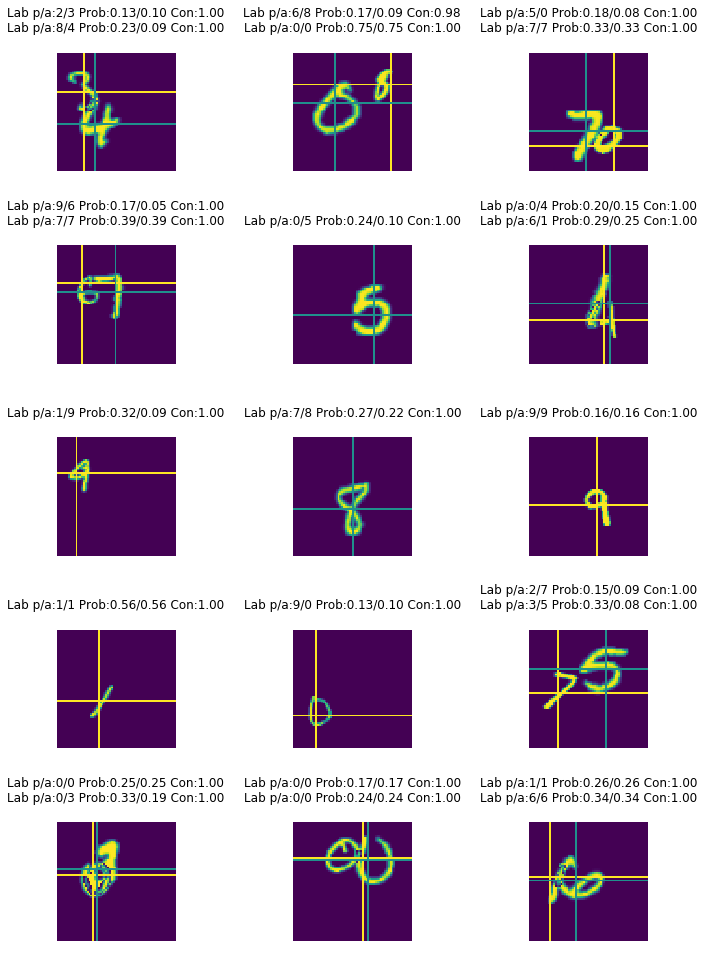

In [17]:
plt.rcParams['figure.figsize'] = (10,40)

dev_batch_size = 15
num_batches = 1

t = generate_inputs(x_train,y_train,batch_size = dev_batch_size, n_classes = 10, large_image_shape=large_image_shape)

batch_counter = 0 
for data in t:
    batch_counter += 1
    predictions = model.predict(data[0],batch_size=dev_batch_size)

    image = data[0]
    n_cols = 3
    n_rows = dev_batch_size
    counter = 0
    img_shape = image[0,:,:,0].shape
    
    for jj in range(dev_batch_size):
        counter += 1
               
        # reshape and draw the lines on the image
        img = image[jj,:,:,:].reshape(img_shape[0],img_shape[1])
        #get the rows and colums of each prediction
        
        title = ''
        for anchor in range(2):
            confidence = predictions[jj,0,0,anchor,2]
            
            if confidence < 0.6: # if confidence is < 0.6, it is not a detection. 
                continue
            
            r = int(predictions[jj,0,0,anchor,0]*img_shape[0])
            c = int(predictions[jj,0,0,anchor,1]*img_shape[1])
            img[r,:] = 1-anchor/2.
            img[:,c] = 1-anchor/2.

            label = np.argmax(data[1][jj,0,0,anchor,3:])
            predicted = np.argmax(predictions[jj,0,0,anchor,3:])
            confidence = predictions[jj,0,0,anchor,2]
            score_predicted = predictions[jj,0,0,anchor,3+predicted]
            score_actual = predictions[jj,0,0,anchor,3+label]
            
            # Title with the predicted/actual labels, score of predicted/actual, 
            #  and the confidence that there is something to be detected
            title += 'Lab p/a:{}/{} Prob:{:.2f}/{:.2f} Con:{:.2f}\n'.format(predicted,
                                                                        label,
                                                                        score_predicted,
                                                                        score_actual,
                                                                        confidence)
            
        plt.subplot(n_rows,n_cols,counter)
        plt.title(title)
        plt.imshow(img)
        plt.axis('off')
        plt.tight_layout()
    plt.show()
    if batch_counter >= num_batches:
        break
